In [1]:
from paragraph_models_utils import (
    load_data, preprocess_data
)
from paragraph_models import (
    FreezeCallback, MultiTaskLearningModel, WikiDataModule,
    BiLSTM_clf, Bert_clf
)
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

seed_everything(42, workers=True)

Global seed set to 42


42

In [23]:
import os
import re
import torch
import json
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast

spacy.prefer_gpu()
# Modello small in inglese di SpaCy per testo scritto (web).
# I modelli medium e large sono piu' grossi e lenti, ma hanno performance
# solo leggermente migliori.
# Anche per Data Analytics e' stato usato questo modello.
nlp = spacy.load("en_core_web_sm")

with open(
    f"datasets/wiki/wiki_dataset.json",
    encoding="utf-8"
) as f_in:
    dataset = json.load(f_in)

In [3]:
dataset["total_pages"]

315

In [4]:
dataset["total_historical_pages"]

122

In [5]:
dataset["total_other_pages"]

193

In [6]:
texts, tags, labels = load_data(dataset, nlp)

train_texts, test_texts, train_tags, test_tags, train_labels, test_labels = train_test_split(
    texts, tags, labels, test_size=0.2, random_state=42, stratify=labels
)
train_texts, valid_texts, train_tags, valid_tags, train_labels, valid_labels = train_test_split(
    train_texts, train_tags, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

Creating tags:   0%|          | 0/12876 [00:00<?, ?it/s]

In [7]:
def correct_text(text):
    result = True
    
    # Il paragrafo è molto corto o molto lungo.
    if len(text) < 20 or len(text) > 480:
        result = False
    
    # Il paragrafo non termina con un punto.
    if text[len(text)-1] != ".":
        result = False
        
    # Il paragrafo contiene una parola con un punto alternato ad altre lettere.
    # Esempio: "a.b", "abc." e ".xyz".
    regex = r"\.\w+"
    for word in text:
        if re.search(regex, word):
            result = False
    
    special_symbols = [':', '|', '\'', '\\']
    for word in text:
        for symbol in special_symbols:
            if symbol in word:
                result = False
        
    # Il paragrafo contiene parole problematiche.
    for word in text:
        if word == "--" or word == "\xa0" or word == "[" or word == "]" \
            or word == "\n" or word == "{" or word == "}" or word == "=" \
            or word == "\ufeff" or word == "...":
                result = False
    
    return result

In [8]:
new_train_texts = train_texts
indices = []
for i in range(len(train_texts)):
    if correct_text(train_texts[i]) == False or all(tag == "O" for tag in train_tags[i]):
        indices.append(i)
        
new_train_texts = np.delete(train_texts, indices, 0)
new_train_tags = np.delete(train_tags, indices, 0)
new_train_labels = np.delete(train_labels, indices, 0)
train_texts = new_train_texts.tolist()
train_tags = new_train_tags.tolist()
train_labels = new_train_labels.tolist() 

In [9]:
new_valid_texts = valid_texts
indices = []
for i in range(len(valid_texts)):
    if correct_text(valid_texts[i]) == False or all(tag == "O" for tag in valid_tags[i]):
        indices.append(i)
        
new_valid_texts = np.delete(valid_texts, indices, 0)
new_valid_tags = np.delete(valid_tags, indices, 0)
new_valid_labels = np.delete(valid_labels, indices, 0)
valid_texts = new_valid_texts.tolist()
valid_tags = new_valid_tags.tolist()
valid_labels = new_valid_labels.tolist() 

In [10]:
new_test_texts = test_texts
indices = []
for i in range(len(test_texts)):
    if correct_text(test_texts[i]) == False or all(tag == "O" for tag in test_tags[i]):
        indices.append(i)
        
new_test_texts = np.delete(test_texts, indices, 0)
new_test_tags = np.delete(test_tags, indices, 0)
new_test_labels = np.delete(test_labels, indices, 0)
test_texts = new_test_texts.tolist()
test_tags = new_test_tags.tolist()
test_labels = new_test_labels.tolist() 

In [11]:
def count_zeros_and_ones(labels):
    zeros = 0
    ones = 0
    
    for label in labels:
        if label == 0:
            zeros += 1
        elif label == 1:
            ones += 1
    
    return zeros, ones

In [12]:
train_zeros, train_ones = count_zeros_and_ones(train_labels)
print("Not historical paragraphs in train set: ", train_zeros)
print("Historical paragraphs in train set: ", train_ones)

Not historical paragraphs in train set:  1390
Historical paragraphs in train set:  1378


In [13]:
valid_zeros, valid_ones = count_zeros_and_ones(valid_labels)
print("Not historical paragraphs in validation set: ", valid_zeros)
print("Historical paragraphs in validation set: ", valid_ones)

Not historical paragraphs in validation set:  313
Historical paragraphs in validation set:  345


In [14]:
test_zeros, test_ones = count_zeros_and_ones(test_labels)
print("Not historical paragraphs in test set: ", test_zeros)
print("Historical paragraphs in test set: ", test_ones)

Not historical paragraphs in test set:  437
Historical paragraphs in test set:  407


In [24]:
total_hist_paragraphs = train_ones + valid_ones + test_ones
total_not_hist_paragraphs = train_zeros + valid_zeros + test_zeros
print("Total historical paragraphs: ", total_hist_paragraphs)
print("Total not historical paragraphs: ", total_not_hist_paragraphs)

Total historical paragraphs:  2130
Total not historical paragraphs:  2140


In [53]:
categories_paragraphs = ['Historical', 'Not historical']
quantities_paragraphs = [total_hist_paragraphs, total_not_hist_paragraphs]
colors = ['red', 'blue']

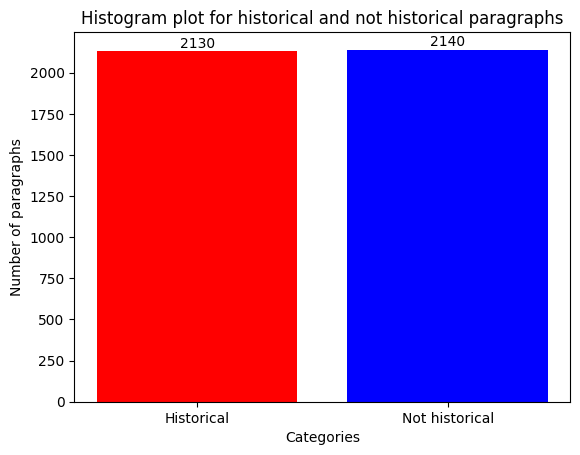

In [56]:
#plt.figure(figsize=(10, 6))
bars = plt.bar(categories_paragraphs, quantities_paragraphs, color=colors)
plt.xlabel('Categories')
plt.ylabel('Number of paragraphs')
plt.title('Histogram plot for historical and not historical paragraphs')
for bar, value in zip(bars, quantities_paragraphs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01, value, ha='center', fontsize=10)
plt.show()

In [16]:
def count_token_tags(tags):
    no_entity = 0
    b_hist = 0
    b_not_hist = 0
    i_hist = 0
    i_not_hist = 0
    
    for i in range(len(tags)):
        for tag in tags[i]:
            if tag == "O":
                no_entity += 1
            elif tag == "B-hist":
                b_hist += 1
            elif tag == "B-not-hist":
                b_not_hist += 1
            elif tag == "I-hist":
                i_hist += 1
            elif tag == "I-not-hist":
                i_not_hist += 1
    
    return no_entity, b_hist, b_not_hist, i_hist, i_not_hist 

In [17]:
train_no_entity, train_b_hist, train_b_not_hist, train_i_hist, train_i_not_hist = count_token_tags(train_tags)
print("No entity tags in train set: ", train_no_entity)
print("Beginning historical tags in train set: ", train_b_hist)
print("Inside historical tags in train set: ", train_i_hist)
print("Beginning not historical tags in train set: ", train_b_not_hist)
print("Inside not historical tags in train set: ", train_i_not_hist)

No entity tags in train set:  240741
Beginning historical tags in train set:  3957
Inside historical tags in train set:  5011
Beginning not historical tags in train set:  7578
Inside not historical tags in train set:  6403


In [18]:
valid_no_entity, valid_b_hist, valid_b_not_hist, valid_i_hist, valid_i_not_hist = count_token_tags(valid_tags)
print("No entity tags in validation set: ", valid_no_entity)
print("Beginning historical tags in validation set: ", valid_b_hist)
print("Inside historical tags in validation set: ", valid_i_hist)
print("Beginning not historical tags in validation set: ", valid_b_not_hist)
print("Inside not historical tags in validation set: ", valid_i_not_hist)

No entity tags in validation set:  57296
Beginning historical tags in validation set:  953
Inside historical tags in validation set:  1288
Beginning not historical tags in validation set:  1834
Inside not historical tags in validation set:  1710


In [19]:
test_no_entity, test_b_hist, test_b_not_hist, test_i_hist, test_i_not_hist = count_token_tags(test_tags)
print("No entity tags in test set: ", test_no_entity)
print("Beginning historical tags in test set: ", test_b_hist)
print("Inside historical tags in test set: ", test_i_hist)
print("Beginning not historical tags in test set: ", test_b_not_hist)
print("Inside not historical tags in test set: ", test_i_not_hist)

No entity tags in test set:  75815
Beginning historical tags in test set:  1224
Inside historical tags in test set:  1657
Beginning not historical tags in test set:  2454
Inside not historical tags in test set:  2104


In [32]:
total_not_entity = train_no_entity + valid_no_entity + test_no_entity
total_b_hist = train_b_hist + valid_b_hist + test_b_hist
total_i_hist = train_i_hist + valid_i_hist + test_i_hist
total_b_not_hist = train_b_not_hist + valid_b_not_hist + test_b_not_hist
total_i_not_hist = train_i_not_hist + valid_i_not_hist + test_i_not_hist

print("Total no entity tags: ", total_not_entity)
print("Total beginning historical tags: ", total_b_hist)
print("Total inside historical tags: ", total_i_hist)
print("Total beginning not historical tags: ", total_b_not_hist)
print("Total inside not historical tags: ", total_i_not_hist)

Total no entity tags:  373852
Total beginning historical tags:  6134
Total inside historical tags:  7956
Total beginning not historical tags:  11866
Total inside not historical tags:  10217


In [36]:
categories_tokens = ['Not-entity', 'B-historical', 'I-historical', 'B-not-historical', 'I-not-historical']
quantities_tokens = [total_not_entity, total_b_hist, total_i_hist, total_b_not_hist, total_i_not_hist]
colors = ['gray', 'red', 'orange', 'blue', 'cyan']

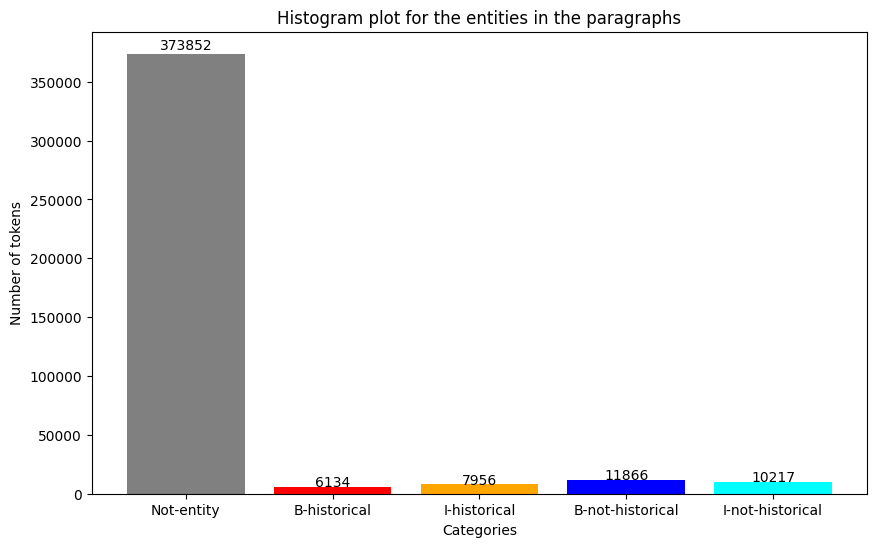

In [52]:
plt.figure(figsize=(10, 6))
bars = plt.bar(categories_tokens, quantities_tokens, color=colors)
plt.xlabel('Categories')
plt.ylabel('Number of tokens')
plt.title('Histogram plot for the entities in the paragraphs')
for bar, value in zip(bars, quantities_tokens):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01, value, ha='center', fontsize=10)
plt.show()